# Import libraries

In [1]:
# python libraries 
from glob import glob
import json
import os
import math

# to split train and test
from sklearn.model_selection import train_test_split

# torch libraries 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# to track progress
from tqdm import tqdm

# for OCR
import pytesseract

# for image operations during text detection
from PIL import Image

# from text detection and data series generation
import pandas as pd
import re

# Set constants

In [2]:
# random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# paths
images_path = "..\\data\\bar_charts\\images\\"
annotations_path = "..\\data\\bar_charts\\annotations\\"
model_path_loss = "..\\model\\ft_frcnn_min_loss.pt"
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\prtkm\AppData\Local\Programs\Tesseract-OCR\tesseract'

# image size
img_size=256

# transformations applied
transform = transforms.Compose([transforms.Grayscale(num_output_channels = 1),
                                transforms.Resize(size = (img_size,img_size), antialias=True),
                                transforms.ToDtype(dtype = torch.float32, scale = True)])

# hyperparameters 
test_size = 0.2
batch_size = 8
lr=0.005
momentum=0.9
weight_decay=0.0005
step_size=3
gamma=0.1
num_epochs = 10
# min loss and min val loss values obtained from previous training results
min_loss = 0.13938654959201813
min_val_loss = 0.23761083572113662

# dict to encode labels
label_encode_dict = {
                        'chart_title':0,
                        'axis_title':1,
                        'tick_label':2,
                        'bar':3,
                        'other':4
                    }

# dict to encode label color for visualization
label_color_dict = {
                        0:'b',
                        1:'g',
                        2:'r',
                        3:'c',
                        4:'k'
                    }

# training and evaluating modes
train_and_eval_model = False
only_eval_model = True

# Create Dataset and DataLoaders

## Create Dataset class

In [3]:
class BarChartDataSet(Dataset):
    
    def __init__(self, path_to_imgs, path_to_json):
        
        # set initial values 
        self.path_to_imgs = path_to_imgs
        self.path_to_json = path_to_json
        self.img_files = glob(self.path_to_imgs + "*.jpg")

    def __getitem__(self, idx):
 
        # get image
        img_path = self.img_files[idx]
        img = read_image(path = img_path)
        
        # Getting original img size
        wt = img.shape[2]
        ht = img.shape[1]
        
        # apply transforms
        img_transformed = transform(img)
        
        # get json annotation of the same image
        json_path = os.path.join(self.path_to_json, img_path[-16:-4]+'.json') 
        json_data = json.load(open(json_path))
        
        # graph is generated or extracted
        source = json_data['source']
        
        # type of graph
        chart_type = json_data['chart-type']
        
        target = {}
        boxes = []
        labels = []
        
        # Extracting text data
        for x in json_data['text']:
            if x['role'] not in label_encode_dict.keys():
                if x['role'] == 'tick_grouping':
                    labels.append(label_encode_dict['tick_label'])
                else:
                    labels.append(label_encode_dict['other'])
            else:
                labels.append(label_encode_dict[x['role']])
            bndbox = []
            # add bbox as xmin, ymin, xmax, ymax
            xcoords = []
            xcoords.append(x['polygon']['x0'])
            xcoords.append(x['polygon']['x1'])
            xcoords.append(x['polygon']['x2'])
            xcoords.append(x['polygon']['x3'])
            ycoords = []
            ycoords.append(x['polygon']['y0'])
            ycoords.append(x['polygon']['y1'])
            ycoords.append(x['polygon']['y2'])
            ycoords.append(x['polygon']['y3'])
            xmin = min(xcoords)
            xmax = max(xcoords)
            ymin = min(ycoords)
            ymax = max(ycoords)
            if xmin==xmax:
                xmax+=0.5
            elif ymin==ymax:
                ymax+=0.5
            bndbox.append((xmin/wt)*img_size) # adjusting for image resize
            bndbox.append((ymin/ht)*img_size) # adjusting for image resize
            bndbox.append((xmax/wt)*img_size) # adjusting for image resize
            bndbox.append((ymax/ht)*img_size) # adjusting for image resize
            boxes.append(bndbox)
        
        # Extracting bar bounding boxes
        for x in json_data['visual-elements']['bars']:
            bndbox = []
            # add bbox as xmin, ymin, xmax, ymax
            labels.append(label_encode_dict['bar'])
            bndbox.append((x['x0']/wt)*img_size) # adjusting for image resize
            bndbox.append((x['y0']/ht)*img_size) # adjusting for image resize
            if x['width'] == 0:
                bndbox.append((x['x0'] + x['width'] + 0.5)/(wt)*img_size) # adjusting for image resize
            else:
                bndbox.append((x['x0'] + x['width'])/(wt)*img_size) # adjusting for image resize
            if x['height'] == 0:
                bndbox.append((x['y0'] + x['height'] + 0.5)/(ht)*img_size) # adjusting for image resize
            else:
                bndbox.append((x['y0'] + x['height'])/(ht)*img_size) # adjusting for image resize
            boxes.append(bndbox)
        
        # convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        wt = torch.tensor(wt, dtype=torch.float32)
        ht = torch.tensor(ht, dtype=torch.int64)
        
        target['boxes'] = boxes
        target['labels'] = labels
        
        # Data series
        data_series = {}
        for elem in json_data['data-series']:
            keys = list(elem.keys())
            data_series[elem[keys[0]]] = elem[keys[1]]
        
        
        return img_transformed, img, source, target, chart_type, wt, ht, data_series

    def __len__(self):
        return len(self.img_files)

## Create DataLoaders

In [4]:
# collate function for use in data loader
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
bcdataset = BarChartDataSet(images_path, annotations_path)

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(bcdataset)),
    test_size=test_size,
    random_state=seed
)

# generate subset based on indices
train_split = Subset(bcdataset, train_indices)
test_split = Subset(bcdataset, test_indices)

print('Training DataSet length = ',len(train_split))
print('Testing DataSet length = ',len(test_split))

# create dataloaders
train_dl = DataLoader(train_split, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_split, batch_size=batch_size, collate_fn=collate_fn)

Training DataSet length =  15409
Testing DataSet length =  3853


In [6]:
# create test subsets for different sources (extracted/generated) and different chart types (vertical_bar/vertical_bar)
extracted = []
generated = []
vertical_bar = []
horizontal_bar = []

# loop over entire test dataset
with tqdm(test_dl, unit="batch") as tepoch:
        tepoch.set_description("Test Dataset Lookup")
        n = 0
        for images, img, source, targets, chart_type, wt, ht, data_series in tepoch:
            for i in range(0,len(source)):
                if source[i] == 'extracted':
                    extracted.append(n+i)
                if source[i] == 'generated':
                    generated.append(n+i)
            for i in range(0,len(chart_type)):
                if chart_type[i] == 'vertical_bar':
                    vertical_bar.append(n+i)
                if chart_type[i] == 'horizontal_bar':
                    horizontal_bar.append(n+i)
            
            n += len(source)

# create splits from indices
test_split_extracted = Subset(test_split, extracted)
test_split_generated = Subset(test_split, generated)
test_split_vertical_bar = Subset(test_split, vertical_bar)
test_split_horizontal_bar = Subset(test_split, horizontal_bar)

print('Extracted Graphs = ',len(test_split_extracted))
print('Generated Graphs = ',len(test_split_generated))
print('Vertical Bar Graphs = ',len(test_split_vertical_bar))
print('Horizontal Bar Graphs = ',len(test_split_horizontal_bar))

# create dataloaders
test_extracted_dl = DataLoader(test_split_extracted, batch_size=batch_size, collate_fn=collate_fn)
test_generated_dl = DataLoader(test_split_generated, batch_size=batch_size, collate_fn=collate_fn)
test_vertical_bar_dl = DataLoader(test_split_vertical_bar, batch_size=batch_size, collate_fn=collate_fn)
test_horizontal_bar_dl = DataLoader(test_split_horizontal_bar, batch_size=batch_size, collate_fn=collate_fn)

Test Dataset Lookup: 100%|██████████| 482/482 [00:14<00:00, 32.96batch/s]

Extracted Graphs =  100
Generated Graphs =  3753
Vertical Bar Graphs =  3837
Horizontal Bar Graphs =  16


## Print sample for one image 

In [7]:
print('length of dataset = ', len(bcdataset))

img_transformed, img, source, target, chart_type, wt, ht, data_series = train_split[0]
print("Transoformed image shape = ",img_transformed.shape)
print("Source = ",source)
print("target = ",target)
print("Chart Type = ",chart_type)
print("Original image width = ",wt)
print("Original image height = ",ht)
print("Data Series = ",data_series)

length of dataset =  19262
Transoformed image shape =  torch.Size([1, 256, 256])
Source =  generated
target =  {'boxes': tensor([[ 30.2146,   6.4229, 227.4335,  29.3620],
        [ 16.4807,  42.2079,  40.6524,  52.3011],
        [ 19.2275,  56.8889,  41.2017,  66.9821],
        [ 19.7768,  69.7348,  41.2017,  79.8280],
        [ 19.7768,  83.4982,  41.2017,  92.6738],
        [ 19.7768,  97.2617,  41.2017, 107.3548],
        [ 19.7768, 111.0251,  41.2017, 121.1183],
        [ 19.7768, 123.8710,  41.2017, 133.9642],
        [ 19.7768, 137.6344,  41.2017, 146.8100],
        [ 19.7768, 151.3978,  41.2017, 161.4910],
        [ 19.7768, 165.1613,  41.2017, 174.3369],
        [ 35.7082, 178.9247,  40.6524, 188.1004],
        [ 42.3004, 191.7706,  58.7811, 218.3799],
        [ 64.8240, 192.6882,  80.7554, 215.6272],
        [ 82.9528, 192.6882, 101.0815, 219.2975],
        [ 91.1931, 185.3477, 123.6051, 239.4839],
        [122.5064, 190.8530, 141.1846, 222.0502],
        [142.8326, 191.7706, 

# Visualization

Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


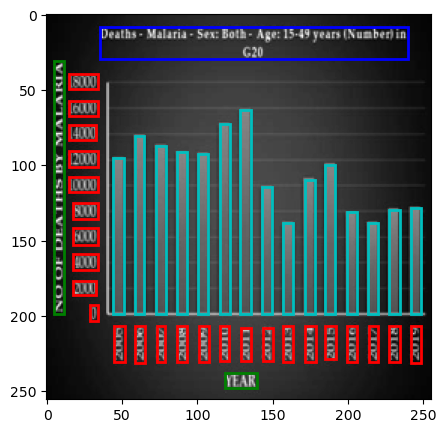

In [8]:
# Function to visualize the image
def plot_img(img):
    # plot the image
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1, 2, 0)
    # plot image
    a.imshow(img, cmap='gray')
    plt.show()
    
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    print("Color Legend")
    for elem in label_encode_dict.keys():
        print(elem,' = ',label_color_dict[label_encode_dict[elem]])
    # plot the image and bboxes
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1, 2, 0)
    # plot image
    a.imshow(img, cmap='gray')
    # plot rectangles for bounding boxes
    for box in range(0, len(target['boxes'])):
        x  = target['boxes'][box][0].cpu()
        y = target['boxes'][box][1].cpu()
        width = (target['boxes'][box][2]-target['boxes'][box][0]).cpu()
        height = (target['boxes'][box][3]-target['boxes'][box][1]).cpu()
        color = label_color_dict[target['labels'][box].item()]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = color,
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes
img_transformed, img, source, target, chart_type, wt, ht, data_series = bcdataset[10]
plot_img_bbox(img_transformed, target)

# Create Faster RCNN Model

In [9]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [10]:
# to train on gpu if available 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(label_encode_dict)

try:
    # get trainined model if possible
    model = torch.load(model_path_loss)
    print("Using Trained Model")
except:
    # get the model using our helper function
    model = get_object_detection_model(num_classes)
    print("Creating new Model")

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,                
                            momentum=momentum, weight_decay=weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=step_size,
                                               gamma=gamma)

Using Trained Model


## Training

### Function to train one epoch

In [11]:
def train_one_epoch(model, optimizer, data_loader, device):
    
    # setting model to train mode
    model.train()

    with tqdm(data_loader, unit="batch") as tepoch:
        tepoch.set_description("Training")
        for images, img, source, targets, chart_type, wt, ht, data_series in tepoch:
            # send everything to gpu
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            with torch.cuda.amp.autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            loss_value = losses.item()

            if not math.isfinite(loss_value):
                print(f"Loss is {loss_value}, stopping training")
                print(loss_dict)
                sys.exit(1)

            # train
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
            # delete stuff to preserve memory
            for img in images:
                del img
            for tar in targets:
                del tar
            for l in loss_dict:
                del l
            del losses
            torch.cuda.empty_cache()
            tepoch.set_postfix(loss=loss_value)
            
    return loss_value

### Function to evaluate results

In [12]:
def evaluate(model, data_loader, device):
    
    # still need model at training mode as faster rcnn only gives losses in training mode
    # while val loss results will be affected, what matters is trend of val loss not val loss itself  
    # therefore it is fine
    model.train() 

    total_loss = 0
    batch_num = 0
    with tqdm(data_loader, unit="batch") as tepoch:
        tepoch.set_description("Evaluating")
        for images, img, source, targets, chart_type, wt, ht, data_series in tepoch:
            batch_num+=1
            # send everything to gpu
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            with torch.no_grad():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            loss_value = losses.item()
            
            total_loss += loss_value
            
            # delete stuff to preserve memory
            for img in images:
                del img
            for tar in targets:
                del tar
            for l in loss_dict:
                del l
            del losses
            torch.cuda.empty_cache()
            tepoch.set_postfix(val_loss=(total_loss/batch_num))
    
    return total_loss/batch_num

### Training and evaluating loop

If train_and_eval_model is set to True then the model will train and evaluate after each epoch. <br>
The model may train for some epochs and then run out of memory. If that happens, try to reduce num_epochs as that helps.

In [13]:
if train_and_eval_model:
    for epoch in range(num_epochs):
        print('Epoch ',(epoch+1),'/',num_epochs)
        # training for one epoch
        loss=train_one_epoch(model, optimizer, train_dl, device)
        if loss<min_loss:
            print("Loss reduced to ",loss)
            min_loss = loss
            print("Saving Min Loss Model")
            torch.save(model, model_path_loss)
        torch.cuda.empty_cache() 
        # update the learning rate
        lr_scheduler.step()
        # eval model
        val_loss= evaluate(model, test_dl, device)
        if val_loss<min_val_loss:
            print("Val Loss reduced to ",val_loss)
            min_val_loss = val_loss
        torch.cuda.empty_cache()    

## Evaluate Faster RCNN model losses

In [14]:
if only_eval_model:
    # eval model
    overall_val_loss= evaluate(model, test_dl, device)
    print("Overall Validation Loss = ",overall_val_loss)
    torch.cuda.empty_cache()
    
    extracted_val_loss= evaluate(model, test_extracted_dl, device)
    print("Validation Loss for Extracted graphs= ",extracted_val_loss)
    torch.cuda.empty_cache()
    
    generated_val_loss= evaluate(model, test_generated_dl, device)
    print("Validation Loss for Generated graphs= ",generated_val_loss)
    torch.cuda.empty_cache()
    
    vb_val_loss= evaluate(model, test_vertical_bar_dl, device)
    print("Validation Loss for Vertical Bar graphs= ",vb_val_loss)
    torch.cuda.empty_cache()
    
    hb_val_loss= evaluate(model, test_horizontal_bar_dl, device)
    print("Validation Loss for Horizontal Bar graphs= ",hb_val_loss)
    torch.cuda.empty_cache()

Evaluating: 100%|██████████| 482/482 [05:29<00:00,  1.46batch/s, val_loss=0.238]


Overall Validation Loss =  0.23761083572113662


Evaluating: 100%|██████████| 13/13 [00:08<00:00,  1.52batch/s, val_loss=0.415]


Validation Loss for Extracted graphs=  0.4152426284093123


Evaluating: 100%|██████████| 470/470 [05:20<00:00,  1.47batch/s, val_loss=0.234]


Validation Loss for Generated graphs=  0.23401844717086628


Evaluating: 100%|██████████| 480/480 [05:21<00:00,  1.49batch/s, val_loss=0.237]


Validation Loss for Vertical Bar graphs=  0.23677640814955037


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.54batch/s, val_loss=0.785]

Validation Loss for Horizontal Bar graphs=  0.78457310795784


# Create function to use Faster RCNN output

## Non Max Suppression to reduce number of boxes

In [15]:
# the function takes the prediction and the iou threshold.

def apply_nms(prediction, iou_thresh=0.3):   
    nms_pred = prediction
    for elem in nms_pred:
        # torchvision returns the indices of the bboxes to keep
        keep = torchvision.ops.nms(elem['boxes'], elem['scores'], iou_thresh)
    
        elem['boxes'] = elem['boxes'][keep]
        elem['scores'] = elem['scores'][keep]
        elem['labels'] = elem['labels'][keep]
    
    return nms_pred


## Apply reverse transformations on boxes to get original bboxes

In [16]:
def rev_transform(preds, wt, ht):
    rev_preds = preds
    for i in range(0,len(rev_preds)):
        if len(rev_preds) == 1:
            rev_preds[i]['boxes'][:, 0] *= wt.item()/img_size
            rev_preds[i]['boxes'][:, 1] *= ht.item()/img_size
            rev_preds[i]['boxes'][:, 2] *= wt.item()/img_size
            rev_preds[i]['boxes'][:, 3] *= ht.item()/img_size
        else:
            rev_preds[i]['boxes'][:, 0] *= wt[i]/img_size
            rev_preds[i]['boxes'][:, 1] *= ht[i]/img_size
            rev_preds[i]['boxes'][:, 2] *= wt[i]/img_size
            rev_preds[i]['boxes'][:, 3] *= ht[i]/img_size
    
    return rev_preds

## Classify bounding boxes and infer chart orientation

In [17]:
def classify_bboxes_and_get_orientation(preds):
    classified_preds = preds
    for elem in classified_preds:
        # to classify bars
        
        # finding bar bounding boxes
        bar_indices = torch.where(elem['labels'] == 3, True, False)
        bar_boxes = elem['boxes'][bar_indices] 
        
        # finding minimum x for all bounding boxes. Will be used below
        bar_min_x = torch.min(bar_boxes[:,0])
        
        # alloting bars
        elem['bar'] = bar_boxes
        
        # to classify axis_title
        
        # finding axis_title bounding boxes
        axis_title_indices = torch.where(elem['labels'] == 1, True, False)
        axis_title_boxes = elem['boxes'][axis_title_indices] 
        
        # finding y axis title
        # y axis title will have their x_max as less then minimum x for bars
        y_indices = torch.where(axis_title_boxes[:,2] < bar_min_x, True, False)
        
        # alloting axis_title
        elem['y_axis_title'] = axis_title_boxes[y_indices]
        elem['x_axis_title'] = axis_title_boxes[~y_indices]
        
        # to classify chart_title
        
        # finding chart_title bounding boxes
        chart_title_indices = torch.where(elem['labels'] == 0, True, False)
        chart_title_boxes = elem['boxes'][chart_title_indices] 
        
        # alloting chart_title
        elem['chart_title'] = chart_title_boxes
        
        # to classify x_ticks and y_ticks
        
        # finding tick_label bounding boxes
        boxes_indices_to_consider = torch.where(elem['labels'] == 2, True, False)
        boxes_to_consider = elem['boxes'][boxes_indices_to_consider]
        
        # finding y indices
        # all y_ticks will have their x_max as less then minimum x for bars
        y_indices = torch.where(boxes_to_consider[:,2] < bar_min_x, True, False)
        
        # alloting x and y ticks
        elem['y_ticks'] = boxes_to_consider[y_indices]
        elem['x_ticks'] = boxes_to_consider[~y_indices]
        
        # delete unwanted keys
        elem.pop('boxes', None)
        elem.pop('labels', None)
        elem.pop('scores', None)
        
        # to get chart orientation
        
        # we check if bars have greater length in x axis or y axis
        # if greater length in x axis then it is a horizontal bar
        # else it is a vertical bar
        
        xlen_ylen_ratios = [(elem[2]-elem[0])/(elem[3]-elem[1]) for elem in bar_boxes]
        xlen_ylen_ratios = torch.tensor(xlen_ylen_ratios, dtype=torch.float32)
        median_val = torch.median(xlen_ylen_ratios)
        if median_val <= 1:
            elem['chart_type'] = 'vertical_bar'
        else:
            elem['chart_type'] = 'horizontal_bar'
    
    return classified_preds

## Get text predictions

### Function to get text inside bounding box

In [18]:
def get_text_from_bb(bb, img):
    apil = transforms.ToPILImage()(img)
    apil = apil.convert('L')
    # crop wants box coordinates as (left, upper, right, lower) with (0,0) in the upper left corner  
    # therefore coordinates will be xmin, ymin, xmax, ymax
    apil_crop = apil.crop((int(bb[0].item()), int(bb[1].item()), int(bb[2].item()), int(bb[3].item())))

    # some text might be rotated 90 deg clockwise therefore we have to rotate 90 deg counterclockwise
    # some text might be rotated 45 deg clockwise therefore we have to rotate 45 deg counterclockwise
    # some text might be rotated 0 deg clockwise therefore we do not rotate it
    # some text might be rotated 45 deg counterclockwise therefore we have to rotate 315 deg counterclockwise
    # some text might be rotated 90 deg counterclockwise therefore we have to rotate 270 deg counterclockwise
    # since we don't know the original orientation of the text, we predict text on all 5 orientations
    # and take the value with highest confidence value

    images = []

    # to rotate 90 deg counterclockwise
    images.append(apil_crop.rotate(angle=90, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white'))

    # to rotate 45 deg counterclockwise
    a = apil_crop.rotate(angle=45, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white')
    # we have to crop it a bit if text is big, then bounding box can also include text from other entities
    w,h = a.size
    a = a.crop((0, int(h/3), w, int(2*h/3)))
    images.append(a)

    # to rotate 0 deg
    images.append(apil_crop)

    # to rotate 315 deg counterclockwise
    a = apil_crop.rotate(angle=315, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white')
    # we have to crop it a bit if text is big, then bounding box can also include text from other entities
    w,h = a.size
    a = a.crop((0, int(h/3), w, int(2*h/3)))
    images.append(a)

    # to rotate 270 deg counterclockwise
    images.append(apil_crop.rotate(angle=270, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white'))

    # predict text all orientations
    conf_text = pd.DataFrame({'conf':[-1.0],'text':[' ']})
    for elem in images:
        ct = pytesseract.image_to_data(elem, output_type='data.frame',config=' --oem 3 --psm 6')
        # get values with confidence != -1 
        ct = ct[ct.conf != -1][['conf', 'text']]
        # add values to conf_text if ct is not empty
        if not ct.empty:
            ct['text'] = ct['text'].astype(str)
            mean_conf = ct.agg({'conf' : ['mean']}).to_numpy()[0][0]
            cat_text = ' '.join(ct.text) 
            # sanitize text
            cat_text_san = re.sub('[^A-Za-z0-9. ]+', '', cat_text).rstrip().lstrip()
            # check ratio of deleted items
            san_ratio = len(cat_text_san)/len(cat_text)
            # only add values if it makes sense
            if san_ratio >= 0.7 and len(cat_text)>1:
                conf_text.loc[-1] = [mean_conf, cat_text_san]
                conf_text = conf_text.reset_index(drop=True)
        
    conf_text = conf_text.loc[conf_text['conf'].idxmax()]
    pred_text = conf_text['text']
    # check if pred_text is float or string
    try:
        pred_text = float(pred_text)
    # this is run when pred_text is a string
    except ValueError:
        # remove . marks
        pred_text = re.sub('[^A-Za-z0-9 ]+', '', pred_text)
    return pred_text

### Function to get text predicitons

In [19]:
def get_text(preds, img):
    text_preds = preds
    if len(text_preds) == 1:
        img = [img]
    for i in range(0,len(text_preds)):
        # classify y_axis_title
        
        # check if it has values
        if text_preds[i]['y_axis_title'].numel() > 0:
            text_preds[i]['y_axis_title_text'] = []
            for elem in text_preds[i]['y_axis_title']:
                text_preds[i]['y_axis_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify x_axis_title
        
        # check if it has values
        if text_preds[i]['x_axis_title'].numel() > 0:
            text_preds[i]['x_axis_title_text'] = []
            for elem in text_preds[i]['x_axis_title']:
                text_preds[i]['x_axis_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify chart_title
        
        # check if it has values
        if text_preds[i]['chart_title'].numel() > 0:
            text_preds[i]['chart_title_text'] = []
            for elem in text_preds[i]['chart_title']:
                text_preds[i]['chart_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify y_ticks
        
        # check if it has values
        if text_preds[i]['y_ticks'].numel() > 0:
            text_preds[i]['y_ticks_text'] = []
            for elem in text_preds[i]['y_ticks']:
                text_preds[i]['y_ticks_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify x_ticks
        
        # check if it has values
        if text_preds[i]['x_ticks'].numel() > 0:
            text_preds[i]['x_ticks_text'] = []
            for elem in text_preds[i]['x_ticks']:
                text_preds[i]['x_ticks_text'].append(get_text_from_bb(elem,img[i]))
    
    return text_preds

## Get Data Series

In [20]:
def get_DS(preds):
    ds_preds = preds
    for elem in ds_preds:
        vpr = 0.0
        ds = {}
        if elem['chart_type'] == 'vertical_bar':
            # get value to pixel ratio
            
            # selecting 2 float indices
            selected_indices = []
            for i in range(0,len(elem['y_ticks'])):
                # check if data is float type
                try:
                    
                    _ = float(elem['y_ticks_text'][i])
                    selected_indices.append(i)
                    if len(selected_indices) == 2:
                        break
                # if not a float
                except ValueError:
                    continue
            
            
            # get lowest ytick as graphs might not start from 0
            float_vals = []
            for i in elem['y_ticks_text']:
                try:
                    _ = float(i)
                    float_vals.append(_)
                except ValueError:
                    continue 
            
            if len(float_vals) > 0:
                min_y_val = min(float_vals)
            else:
                min_y_val = 0
            min_y_ymax = min(elem['y_ticks'][:,3])
            
            if len(selected_indices) == 2:
                value_difference = abs(float(elem['y_ticks_text'][selected_indices[1]]) - float(elem['y_ticks_text'][selected_indices[0]]))
                pixel_difference = abs(elem['y_ticks'][selected_indices[0]][3] - elem['y_ticks'][selected_indices[1]][3])
                vpr = value_difference/pixel_difference
            else:
                # default bad case
                vpr = 1
            
            # sort xticks according to xmax values
            ind = elem['x_ticks'][:,2].argsort(dim=0)
            xticks = elem['x_ticks'][ind]
            xtick_text = [elem['x_ticks_text'][i] for i in ind]
            
            # sort bars according to xmax values
            ind = elem['bar'][:,2].argsort(dim=0)
            bars = elem['bar'][ind]
            
            # create a variable to track length to bar as it is possible that we detect less bar than xticks
            num_bars = len(bars)
                
            # start creating ds dict
            for i in range(0,len(xticks)):
                # identify key
                key = xtick_text[i]
                
                if i >= num_bars:
                    # find len of selected bar
                    bar_val = abs(bars[num_bars-1][3] - bars[num_bars-1][1])
                else:
                    # find len of selected bar
                    bar_val = abs(bars[i][3] - bars[i][1])
                    
                # value of bar = length * vpr
                bar_val *= vpr
                # value of bar = val + min y value
                bar_val += min_y_val 
                
                ds[key] = bar_val.item()
        
        else:
            # get value to pixel ratio
            
            # selecting 2 float indices
            selected_indices = []
            for i in range(0,len(elem['x_ticks'])):
                # check if data is float type
                try:
                    
                    _ = float(elem['x_ticks_text'][i])
                    selected_indices.append(i)
                    if len(selected_indices) == 2:
                        break
                # if not a float
                except ValueError:
                    continue
            
            
            # get lowest xtick as graphs might not start from 0
            float_vals = []
            for i in elem['x_ticks_text']:
                try:
                    _ = float(i)
                    float_vals.append(_)
                except ValueError:
                    continue 
            
            if len(float_vals) > 0:
                min_x_val = min(float_vals)
            else:
                min_x_val = 0
            min_x_xmax = min(elem['x_ticks'][:,2])
            
            if len(selected_indices) == 2:
                value_difference = abs(float(elem['x_ticks_text'][selected_indices[1]]) - float(elem['x_ticks_text'][selected_indices[0]]))
                pixel_difference = abs(elem['x_ticks'][selected_indices[0]][2] - elem['x_ticks'][selected_indices[1]][2])
                vpr = value_difference/pixel_difference
            else:
                # default bad case
                vpr = 1
            
            # sort yticks according to ymax values
            ind = elem['y_ticks'][:,3].argsort(dim=0)
            yticks = elem['y_ticks'][ind]
            ytick_text = [elem['y_ticks_text'][i] for i in ind]
            
            # sort bars according to ymax values
            ind = elem['bar'][:,3].argsort(dim=0)
            bars = elem['bar'][ind]
            
            # create a variable to track length to bar as it is possible that we detect less bar than xticks
            num_bars = len(bars)
                
            # start creating ds dict
            for i in range(0,len(yticks)):
                # identify key
                key = ytick_text[i]
                
                if i >= num_bars:
                    # find len of selected bar
                    bar_val = abs(bars[num_bars-1][2] - bars[num_bars-1][0])
                else:
                    # find len of selected bar
                    bar_val = abs(bars[i][2] - bars[i][0])
                    
                # value of bar = length * vpr
                bar_val *= vpr
                # value of bar = val + min y value
                bar_val += min_x_val 
                
                ds[key] = bar_val.item()
        
        
        
        elem['data_series'] = ds
        

    return ds_preds

# Print results for one image

## Print outputs of bounding box detection

real #boxes:  41
nms predicted #boxes:  40

Actual Image


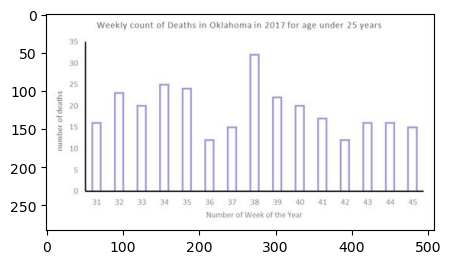

Ground Truth
Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


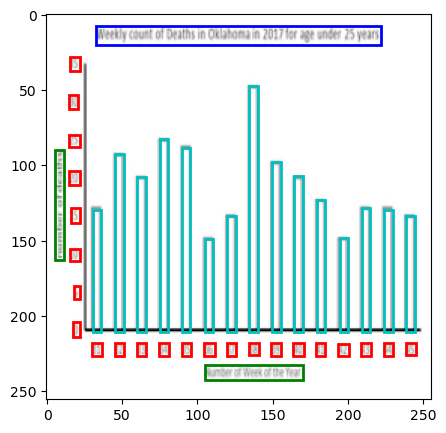

NMS APPLIED MODEL OUTPUT
Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


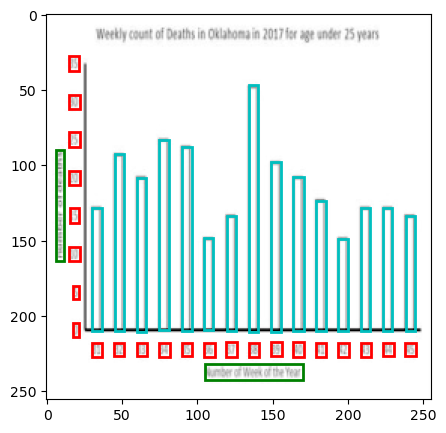

Actual size bounding boxes
Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


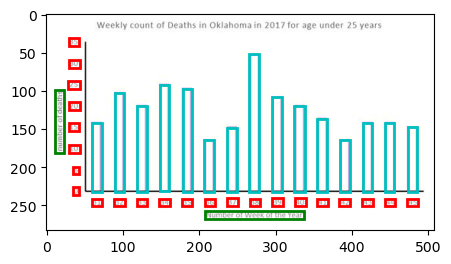

In [21]:
# pick one image from the test set
# index chosen at random from test indices
img_transformed, img, source, target, chart_type, wt, ht, data_series = test_split[50] 
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img_transformed.to(device)])
    
print('real #boxes: ', len(target['labels']))
nms_prediction = apply_nms(prediction)
print('nms predicted #boxes: ', len(nms_prediction[0]['labels']))
print()
print('Actual Image')
plot_img(img)
print("Ground Truth")
plot_img_bbox(img_transformed, target)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img_transformed, nms_prediction[0])
rev_pred = rev_transform(nms_prediction, wt, ht)
print('Actual size bounding boxes')
plot_img_bbox(img, rev_pred[0])

### Observations

- Model is performing well at detecting axis_title
- Model performs well at detecting bar but can get confused when only vertical grid lines are shown
- Model normally performs well at detecting tick_label but tends to miss sometimes when bigger text at +-45 degree are involved
- Model is consistently not able to detect chart_title
- In some cases, the model is predicting a lot of overlapping boxes but this issue has been sorted by the use of Non Max Suppression

## Print outputs of text detection and data series generation

In [22]:
classified = classify_bboxes_and_get_orientation(rev_pred)
text_preds_classified = get_text(classified, img)
ds_pred = get_DS(text_preds_classified)

if ds_pred[0]['chart_title'].numel()>0:
    print("Chart Title = ",ds_pred[0]['chart_title_text'][0])
    
if ds_pred[0]['y_axis_title'].numel()>0: 
    print('Y Axis Title = ', ds_pred[0]['y_axis_title_text'][0])

if ds_pred[0]['x_axis_title'].numel()>0: 
    print('X Axis Title = ', ds_pred[0]['x_axis_title_text'][0])

ds = ds_pred[0]['data_series']
ds = pd.DataFrame([ds])

print('Data Series')
print(ds)

Y Axis Title =  number of deaths
X Axis Title =  Number of Week of the Year
Data Series
                  32.0       33.0      34.0        5.0      36.0       37.0  \
0  16.16395  23.258537  20.144011  25.03306  24.259335  12.09214  15.082733   

          a8       39.0       40.0       41.0      42.0       43.0         A4  \
0  32.363762  22.353775  20.213669  17.080166  12.17448  16.205967  16.089178   

        45.0  
0  15.171492  
